In [1]:
from sklearn.cluster import DBSCAN


In [2]:
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.model_selection import KFold
# import numpy as np
import pandas as pd

In [3]:
from create_matrix import *

from tensor_custom_core import *
from create_matrix import *
from tensor_custom_core import *
from degree_days import dds
appliance_index = {appliance: APPLIANCES_ORDER.index(appliance) for appliance in APPLIANCES_ORDER}

APPLIANCES = ['fridge', 'hvac', 'wm', 'mw', 'oven', 'dw']
region = "SanDiego"
year = 2014

import os
from degree_days import dds
import autograd.numpy as np




def un_normalize(x, maximum, minimum):
    return (maximum - minimum) * x + minimum

In [4]:
def get_tensor(df):
    start, stop = 1, 13
    energy_cols = np.array(
        [['%s_%d' % (appliance, month) for month in range(start, stop)] for appliance in APPLIANCES_ORDER]).flatten()

    dfc = df.copy()

    df = dfc[energy_cols]

    tensor = df.values.reshape((len(df), 7, stop - start))
    return tensor


def create_region_df_dfc_static(region, year):
    df, dfc = create_matrix_single_region(region, year)
    tensor = get_tensor(df)
    static_region = df[['area', 'total_occupants', 'num_rooms']].copy()
    static_region['area'] = static_region['area'].div(4000)
    static_region['total_occupants'] = static_region['total_occupants'].div(8)
    static_region['num_rooms'] = static_region['num_rooms'].div(8)
    static_region =static_region.values
    return df, dfc, tensor, static_region


In [5]:
au_df, au_dfc, au_tensor, au_static = create_region_df_dfc_static('Austin', year)
sd_df, sd_dfc, sd_tensor, sd_static = create_region_df_dfc_static('SanDiego', year)

In [6]:
import pickle

def load_obj(name):
    with open(os.path.expanduser('~/git/' + name + '.pkl'), 'rb') as f:
        try:
            return pickle.load(f)
        except EOFError:
            return None

## load the graph laplacian results

In [8]:
pred_graph = {}
for method in ['normal', 'transfer']:
    pred_graph[method] = {}
    for lam in [0.001, 0.01, 0.1, 0, 1]:
        lam = float(lam)
        pred_graph[method][lam] = load_obj("graph_test_static/{}_{}".format(method, lam))

In [9]:
from common import compute_rmse_fraction

out_graph = {}
for method in ['normal', 'transfer']:
    out_graph[method] = {}
    for lam in [0.001, 0.01, 0.1, 0, 1]:
        out_graph[method][lam] = {}
        for random_seed in range(5):
            print method, lam, random_seed
            out_graph[method][lam][random_seed] = {}
            for appliance in APPLIANCES_ORDER[1:]:
                out_graph[method][lam][random_seed][appliance] = {}
                for f in range(10, 110, 20):
                    s = pd.concat(pred_graph[method][lam][random_seed][appliance][f]).ix[sd_df.index]
                    if appliance=="hvac":
                        out_graph[method][lam][random_seed][appliance][f] = compute_rmse_fraction(appliance,s[range(4, 10)],'SanDiego')[2]
                    else:
                        out_graph[method][lam][random_seed][appliance][f] = compute_rmse_fraction(appliance, s,'SanDiego')[2]


normal 0.001 0


/home/yj9xs/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:14: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate_ix


normal 0.001 1
normal 0.001 2
normal 0.001 3
normal 0.001 4
normal 0.01 0
normal 0.01 1
normal 0.01 2
normal 0.01 3
normal 0.01 4
normal 0.1 0
normal 0.1 1
normal 0.1 2
normal 0.1 3
normal 0.1 4
normal 0 0
normal 0 1
normal 0 2
normal 0 3
normal 0 4
normal 1 0
normal 1 1
normal 1 2
normal 1 3
normal 1 4
transfer 0.001 0
transfer 0.001 1
transfer 0.001 2
transfer 0.001 3
transfer 0.001 4
transfer 0.01 0
transfer 0.01 1
transfer 0.01 2
transfer 0.01 3
transfer 0.01 4
transfer 0.1 0
transfer 0.1 1
transfer 0.1 2
transfer 0.1 3
transfer 0.1 4
transfer 0 0
transfer 0 1
transfer 0 2
transfer 0 3
transfer 0 4
transfer 1 0
transfer 1 1
transfer 1 2
transfer 1 3
transfer 1 4


### Read the results with/without static factors

In [20]:
pred = {}
for method in ['normal', 'transfer']:
    pred[method] = {}
    for static_fac in ['static', 'None']:
        pred[method][static_fac] = {}
        for random_seed in range(5):
            pred[method][static_fac][random_seed] = load_obj("pred_explore/pred_{}_2000_adagrad_{}_0.0_{}".format(method, static_fac, random_seed))

In [21]:
out = {}
for method in ['normal', 'transfer']:
    out[method] = {}
    for static_fac in ['static', 'None']:
        out[method][static_fac] = {}
        for random_seed in range(5):
            out[method][static_fac][random_seed] = {}
            for appliance in APPLIANCES_ORDER[1:]:
                out[method][static_fac][random_seed][appliance] = {}
                for f in range(10, 110, 20):
                    s = pd.concat(pred[method][static_fac][random_seed][appliance][f]).ix[sd_df.index]
                    if appliance=="hvac":
                        out[method][static_fac][random_seed][appliance][f] = compute_rmse_fraction(appliance,s[range(4, 10)],'SanDiego')[2]
                    else:
                        out[method][static_fac][random_seed][appliance][f] = compute_rmse_fraction(appliance, s,'SanDiego')[2]


/home/yj9xs/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:11: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate_ix


In [12]:
mean_graph = {}
for method in ['normal', 'transfer']:
    mean_graph[method] = {}
    for lam in [0.001, 0.01, 0.1, 0, 1]:
        lam = float(lam)
        mean_graph[method][lam] = pd.Panel(out_graph[method][lam]).mean(axis=0)

In [22]:
mean = {}
for method in ['normal', 'transfer']:
    mean[method] = {}
    for static_fac in ['static', 'None']:
        mean[method][static_fac] = pd.Panel(out[method][static_fac]).mean(axis=0)

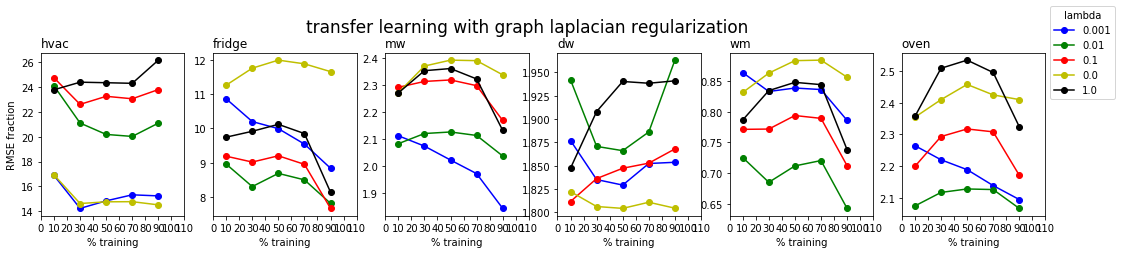

In [23]:
fig, axes = plt.subplots(nrows=1, ncols=6, figsize=(50, 80))
ax = axes.flatten()
count = 0
method = 'transfer'

for appliance in APPLIANCES_ORDER[1:]:

    df1 = mean_graph[method][0.001][appliance]
    df2 = mean_graph[method][0.01][appliance]
    df3 = mean_graph[method][0.1][appliance]
    df4 = mean_graph[method][0.0][appliance]
    df5 = mean_graph[method][1.0][appliance]
    df = pd.concat([df1, df2, df3,df4, df5], axis = 1)
    
    
    
    pd.DataFrame(df).plot(ax=ax[count],figsize=(18, 3), marker='o', xlim=(0, 110), color=['b', 'g','r', 'y', 'k', 'c'])
    ax[count].legend(loc='best', bbox_to_anchor=(1.0, 0.5))


#     major_ticks = np.arange(0, 101, 20)

    ax[count].set_xlabel("% training");
    ax[count].locator_params(tight=False, nbins=20, axis='x')
    ax[count].set_title(appliance, loc="left")
    ax[count].legend().set_visible(False)
    count += 1
ax[0].set_ylabel('RMSE fraction')
plt.suptitle('{} learning with graph laplacian regularization'.format(method), fontsize=17,y=1.04)

# ax[count-1].legend(["normal", 'transfer'], loc='center left' , bbox_to_anchor=(1, 1))

ax[count-1].legend(["0.001",'0.01', '0.1', '0.0', '1.0'], loc='center left' , bbox_to_anchor=(1, 1), title="lambda")
# plt.savefig("./analysis/08/normal_graph_lam.pdf", bbox_inches="tight", dpi=300, format='pdf')

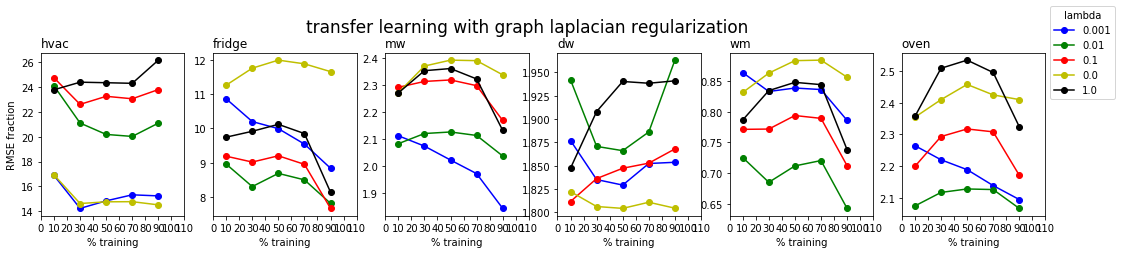

In [24]:
fig, axes = plt.subplots(nrows=1, ncols=6, figsize=(50, 80))
ax = axes.flatten()
count = 0
method = 'transfer'

for appliance in APPLIANCES_ORDER[1:]:

    df1 = mean_graph[method][0.001][appliance]
    df2 = mean_graph[method][0.01][appliance]
    df3 = mean_graph[method][0.1][appliance]
    df4 = mean_graph[method][0.0][appliance]
    df5 = mean_graph[method][1.0][appliance]
    df = pd.concat([df1, df2, df3,df4, df5], axis = 1)
    
    
    
    pd.DataFrame(df).plot(ax=ax[count],figsize=(18, 3), marker='o', xlim=(0, 110), color=['b', 'g','r', 'y', 'k', 'c'])
    ax[count].legend(loc='best', bbox_to_anchor=(1.0, 0.5))


#     major_ticks = np.arange(0, 101, 20)

    ax[count].set_xlabel("% training");
    ax[count].locator_params(tight=False, nbins=20, axis='x')
    ax[count].set_title(appliance, loc="left")
    ax[count].legend().set_visible(False)
    count += 1
ax[0].set_ylabel('RMSE fraction')
plt.suptitle('{} learning with graph laplacian regularization'.format(method), fontsize=17,y=1.04)

# ax[count-1].legend(["normal", 'transfer'], loc='center left' , bbox_to_anchor=(1, 1))

ax[count-1].legend(["0.001",'0.01', '0.1', '0.0', '1.0'], loc='center left' , bbox_to_anchor=(1, 1), title="lambda")
# plt.savefig("./analysis/08/normal_graph_lam.pdf", bbox_inches="tight", dpi=300, format='pdf')

In [70]:
mean_graph['normal'][0.001]

,dw,fridge,hvac,mw,oven,wm
10,2.436023,9.104420,20.737426,2.036351,4.156014,5.825866
30,2.186285,7.119999,15.854081,1.744171,2.230717,0.970324
50,1.976657,6.105327,14.396847,1.769845,2.137370,0.830681
70,1.963693,5.826570,14.185261,1.766031,2.116798,0.698723
90,1.960680,4.884244,14.004617,1.662284,2.130102,0.634636


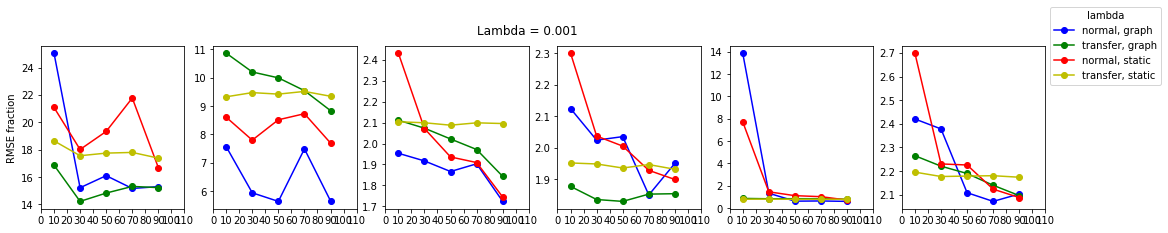

In [30]:
fig, axes = plt.subplots(nrows=1, ncols=6)
# fig.tight_layout()
ax = axes.flatten()
count = 0
algo = 'gd'
lam = 0.001

for lam in [0.001]:
    lam = float(lam)
    plt.suptitle("Lambda = {}".format(lam))
    for appliance in APPLIANCES_ORDER[1:]:

        df1 = mean_graph['normal'][lam][appliance]
        df2 = mean_graph['transfer'][lam][appliance]
        df3 = mean['normal']['static'][appliance]
        df4 = mean['transfer']['static'][appliance]

        df = pd.concat([df1, df2, df3, df4], axis = 1)



        pd.DataFrame(df).plot(ax=ax[count],figsize=(18, 3), marker='o', xlim=(0, 110), color=['b', 'g','r', 'y', 'k', 'c'])
        ax[count].legend(loc='best', bbox_to_anchor=(1.0, 0.5))


    #     major_ticks = np.arange(0, 101, 20)

#         ax[count].set_xlabel("% training");
        ax[count].locator_params(tight=False, nbins=20, axis='x')
#         ax[count].set_title(appliance, loc="left")
        ax[count].legend().set_visible(False)
        count += 1
ax[0].set_ylabel('RMSE fraction')
# plt.suptitle('Normal learning with graph laplacian regularization', fontsize=17,y=1.04)

# ax[count-1].legend(["normal", 'transfer'], loc='center left' , bbox_to_anchor=(1, 1))

ax[count-1].legend(["normal, graph",'transfer, graph', 'normal, static', 'transfer, static'], loc='center left' , bbox_to_anchor=(1, 1), title="lambda")
# plt.savefig("./analysis/08/normal_graph_lam.pdf", bbox_inches="tight", dpi=300, format='pdf')

In [16]:
from common import APPLIANCES_ORDER, contri

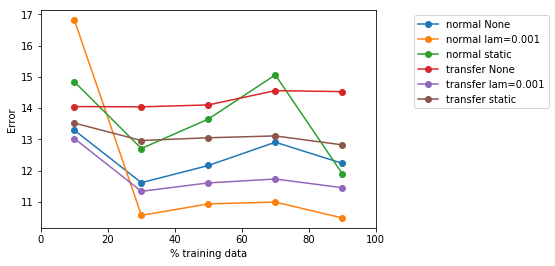

In [28]:
overall_res = {}
for method in ['normal', 'transfer']:
    for lam in [0.001]:
        lam = float(lam)
        overall_res["{} lam={}".format(method, lam)] = (mean_graph[method][lam]*pd.Series(contri['SanDiego'])).sum(axis=1)

for method in ['normal', 'transfer']:
    for static_fac in ['static', 'None']:
        overall_res["{} {}".format(method, static_fac)] = (mean[method][static_fac]*pd.Series(contri['SanDiego'])).sum(axis=1)
        
pd.DataFrame(overall_res).plot(marker='o')

plt.legend(bbox_to_anchor=(1.1, 1))
plt.ylabel("Error")
plt.xlim((0, 100))
plt.xlabel("% training data")


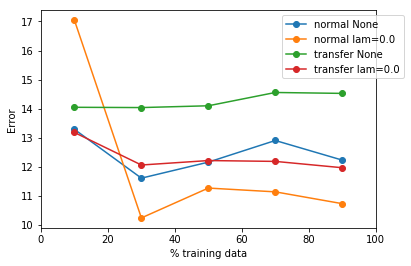

In [32]:
overall_res = {}
for method in ['normal', 'transfer']:
    for lam in [0]:
        lam = float(lam)
        overall_res["{} lam={}".format(method, lam)] = (mean_graph[method][lam]*pd.Series(contri['SanDiego'])).sum(axis=1)

for method in ['normal', 'transfer']:
    for static_fac in [ 'None']:
        overall_res["{} {}".format(method, static_fac)] = (mean[method][static_fac]*pd.Series(contri['SanDiego'])).sum(axis=1)
        
pd.DataFrame(overall_res).plot(marker='o')

plt.legend(bbox_to_anchor=(1.1, 1))
plt.ylabel("Error")
plt.xlim((0, 100))
plt.xlabel("% training data")
